# Dynamical blockade in a Single-Model Bosonic System

Based on paper: DOI: https://doi.org/10.1103/PhysRevLett.123.013602

In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt

from torchqc.states import QuantumState
from torchqc.common_functions import get_density_matrix, expect_val_dm
from torchqc.operators import DynamicOperator
from torchqc.common_matrices import annihilation, creation
from torchqc.dynamics import lindblad_equation
from torchqc.correlation import correlation_fn_2op_1time

import torch

* Initial state is a coherent state

$\ket{\psi} = \ket{b}$

In [2]:
N = 50 # number of fock states
b1 = 0.1
coherent_state = QuantumState.coherent(N, b1)

initial_state = coherent_state

* Simulate dynamics

In [3]:
Dt = 0.01

γ = 1
U = 0.05 * γ  # nonlinear coupling
E = 2 * γ
m = 10
T_period = 18.5 * γ
P0 = 0.2 * γ
P1 = 1 * γ

time = np.arange(0, 100, Dt)

* Hamiltonian of a bosonic Josephson junctions with two quantuzed modes (Bos-Hubband approximation)

$H = \Epsilon a^\dagger a + U a^\dagger a^\dagger a a + P(t) a^\dagger + P^{*}(t) a$

In [4]:
a_dagger = creation(N)
a = annihilation(N)

N_op = a_dagger * a

In [5]:
def delta_fn(t, to):
    if t == to:
        return 1e5
    else:
        return 0

def Pt(t):
    sum_term = 0

    for i in range(m):
        # sum_term += delta_fn(t, i * T_period)
        sum_term += nornal_distr(i * T_period, 0.01, t)

    p_t = P0 + P1 * sum_term

    return p_t

def nornal_distr(μ, σ, t):
    return (1 / np.sqrt(2 * np.pi * σ**2)) * np.exp(- (t - μ)**2 / (2 * σ**2))

In [6]:
def Ht(t, params=[]):
    H1 = E * N_op + U * a_dagger * a_dagger * a * a 

    p_t = Pt(t)

    H2 = p_t * a_dagger + p_t * a

    H = H1 + H2

    return H.matrix

hamiltonian = DynamicOperator(N, Ht, time=time)

/tmp/ipykernel_60484/1462076046.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (1 / np.sqrt(2 * np.pi * σ**2)) * np.exp(- (t - μ)**2 / (2 * σ**2))


* Simulate dynamics with von-Neumann equations

In [7]:
rho = get_density_matrix(initial_state)

jump_ops = [a]
rates = [γ]

_, states = lindblad_equation(rho, hamiltonian, time, Dt, jump_ops, rates)

In [8]:
expectation_values_N = expect_val_dm(states, N_op)

In [9]:
G2 = torch.tensor([torch.real(torch.trace((a_dagger * a_dagger * a * a * state).matrix)) for state in states])
g2 = G2 / (expectation_values_N ** 2)

In [10]:
time_tensor = torch.from_numpy(time).reshape(len(time), 1)
P_t = [Pt(t) for t in time_tensor]

/tmp/ipykernel_60484/1462076046.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (1 / np.sqrt(2 * np.pi * σ**2)) * np.exp(- (t - μ)**2 / (2 * σ**2))


Text(0.5, -0.5, '(c)')

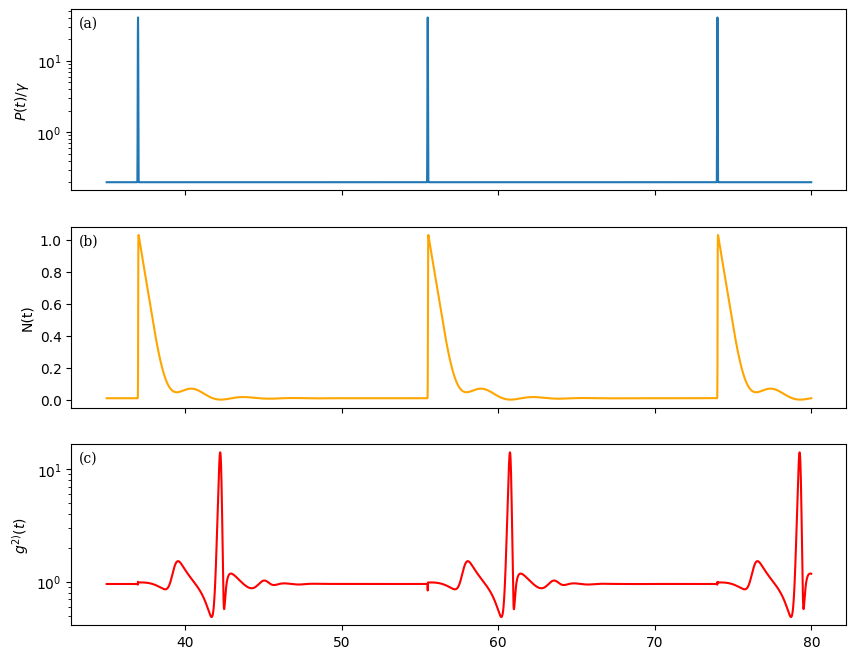

In [11]:
fig, axs = plt.subplots(3, 1, sharex='col')

fig.set_figheight(8)
fig.set_figwidth(10)

pulse_fig = axs[0]
pop_fig = axs[1]
corr_fig = axs[2]

pulse_fig.plot(time[3500:8000], P_t[3500:8000], label=r"$P(t)$")
pulse_fig.set_ylabel(r"$P(t) / \gamma$")
pulse_fig.set_yscale("log")

pulse_fig.annotate(
        "(a)",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',)

pop_fig.plot(time[3500:8000], expectation_values_N[3500:8000], color="orange", label=r"N(t)")
pop_fig.set_ylabel(r"N(t)")

pop_fig.annotate(
        "(b)",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',)

corr_fig.plot(time[3500:8000], g2[3500:8000], color="red", label=r"$g^{(2)}$")
corr_fig.set_ylabel(r"$g^{2)}(t)$")
corr_fig.set_yscale("log")
corr_fig.annotate(
        "(c)",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',)